In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.1


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


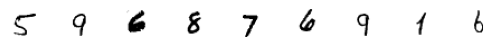

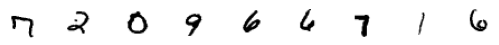

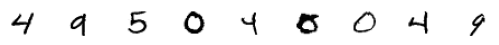

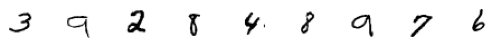

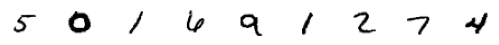

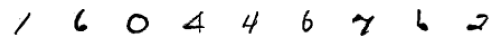

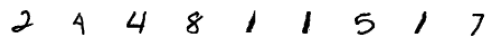

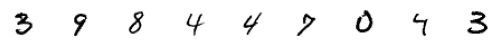

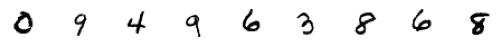

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(9, 6))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

In [4]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [5]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model

In [6]:
random_input = tensorflow.keras.layers.Input(shape = 100)

x = tensorflow.keras.layers.Dense(7*7*128)(random_input)
x = tensorflow.keras.layers.Reshape((7, 7, 128))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, padding='same')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, padding='same')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), padding='same')(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(4,4), padding='same')(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       147584

# Critic

In [7]:
# custom loss function
def wasserstein_loss(y_true, y_pred):
    return tensorflow.keras.backend.mean(y_true * y_pred)

In [8]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same')(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)

x = tensorflow.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)

x = tensorflow.keras.layers.Flatten()(x)

c_out = tensorflow.keras.layers.Dense(1)(x)

critic_network = tensorflow.keras.models.Model(inputs=image_input, outputs=c_out)

print (critic_network.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0   

# Compiling Classisfiers

In [9]:
RMSprop_optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.00005)
critic_network.compile(loss=wasserstein_loss, optimizer=RMSprop_optimizer, metrics=['accuracy'])

# W-GAN

In [10]:
critic_network.trainable=False

g_output = generator_network(random_input)
c_output = critic_network(g_output)

wgan_model = tensorflow.keras.models.Model(inputs = random_input, outputs = c_output)
wgan_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Functional)           (None, 28, 28, 1)         1079297   
_________________________________________________________________
model_1 (Functional)         (None, 1)                 523393    
Total params: 1,602,690
Trainable params: 1,078,785
Non-trainable params: 523,905
_________________________________________________________________


# Compiling WGAN

In [11]:
wgan_model.compile(loss=wasserstein_loss, optimizer=RMSprop_optimizer)

# Define Data Generators

In [12]:
indices = [i for i in range(0, len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batches

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batches)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(7):
        plt.figure(figsize=(9, 6))
        random_noise_batches = get_random_noise(7, noise_size) 
        fake_samples = generator_network.predict_on_batch(random_noise_batches)
        for j in range(7):
            i = j
            plt.subplot(770 + 1 + j)
            plt.imshow(((fake_samples[i,:,:,-1])/2.0)+0.5, cmap='gray_r')
            plt.axis('off')
        plt.show()
    return

# Training GAN

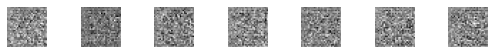

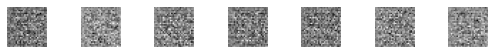

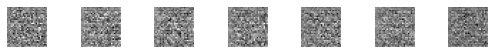

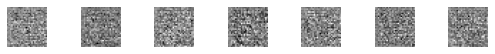

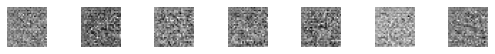

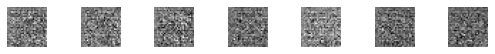

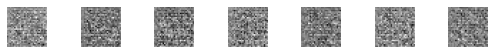

Epoch:0, Step:0, C-Loss:0.000156, G-Loss:-0.000021
Epoch:0, Step:50, C-Loss:-0.005784, G-Loss:-0.002175
Epoch:0, Step:100, C-Loss:0.000427, G-Loss:-0.001326
Epoch:0, Step:150, C-Loss:0.000180, G-Loss:-0.000154
Epoch:0, Step:200, C-Loss:-0.000305, G-Loss:-0.000005
Epoch:0, Step:250, C-Loss:0.000056, G-Loss:-0.000116
Epoch:0, Step:300, C-Loss:0.000084, G-Loss:-0.000012
Epoch:0, Step:350, C-Loss:0.000041, G-Loss:-0.000040
Epoch:0, Step:400, C-Loss:0.000042, G-Loss:-0.000031
Epoch:0, Step:450, C-Loss:0.000030, G-Loss:0.000044


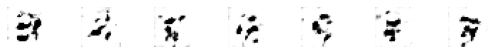

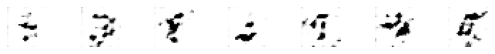

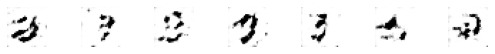

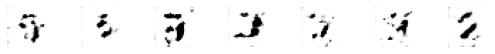

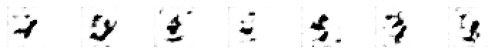

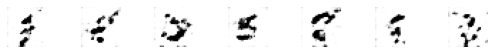

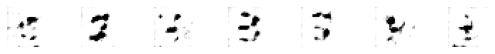

Epoch:1, Step:0, C-Loss:0.000032, G-Loss:-0.000021
Epoch:1, Step:50, C-Loss:0.000023, G-Loss:0.000136
Epoch:1, Step:100, C-Loss:-0.000208, G-Loss:0.001741
Epoch:1, Step:150, C-Loss:-0.000153, G-Loss:0.002221
Epoch:1, Step:200, C-Loss:-0.000225, G-Loss:0.002448
Epoch:1, Step:250, C-Loss:-0.000052, G-Loss:0.002467
Epoch:1, Step:300, C-Loss:-0.000037, G-Loss:0.003418
Epoch:1, Step:350, C-Loss:0.000043, G-Loss:0.003370
Epoch:1, Step:400, C-Loss:0.000167, G-Loss:0.003937
Epoch:1, Step:450, C-Loss:0.000138, G-Loss:0.004801


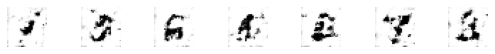

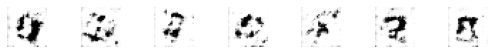

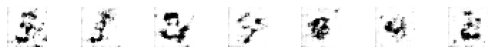

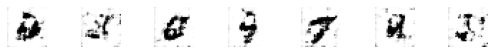

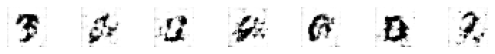

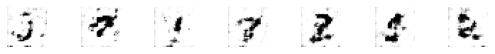

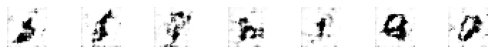

Epoch:2, Step:0, C-Loss:-0.000079, G-Loss:0.005856
Epoch:2, Step:50, C-Loss:-0.000849, G-Loss:0.006990
Epoch:2, Step:100, C-Loss:-0.000924, G-Loss:0.007532
Epoch:2, Step:150, C-Loss:-0.001179, G-Loss:0.008226
Epoch:2, Step:200, C-Loss:-0.001751, G-Loss:0.008950
Epoch:2, Step:250, C-Loss:-0.001285, G-Loss:0.009451
Epoch:2, Step:300, C-Loss:-0.000656, G-Loss:0.009679
Epoch:2, Step:350, C-Loss:-0.000666, G-Loss:0.009280
Epoch:2, Step:400, C-Loss:-0.001696, G-Loss:0.010529
Epoch:2, Step:450, C-Loss:-0.000676, G-Loss:0.009999


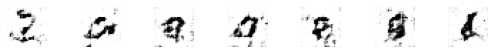

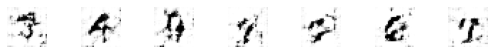

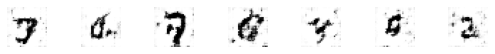

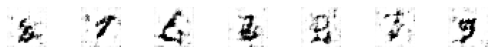

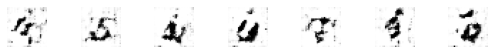

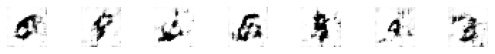

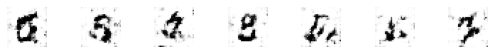

Epoch:3, Step:0, C-Loss:-0.000786, G-Loss:0.010787
Epoch:3, Step:50, C-Loss:-0.000459, G-Loss:0.010189
Epoch:3, Step:100, C-Loss:-0.000730, G-Loss:0.010504
Epoch:3, Step:150, C-Loss:-0.000386, G-Loss:0.011014
Epoch:3, Step:200, C-Loss:-0.000264, G-Loss:0.010744
Epoch:3, Step:250, C-Loss:-0.001864, G-Loss:0.011276
Epoch:3, Step:300, C-Loss:0.000717, G-Loss:0.011177
Epoch:3, Step:350, C-Loss:-0.000801, G-Loss:0.011035
Epoch:3, Step:400, C-Loss:-0.000023, G-Loss:0.011302
Epoch:3, Step:450, C-Loss:-0.000319, G-Loss:0.010991


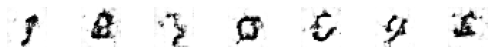

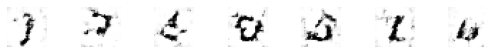

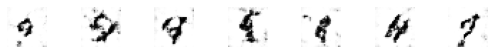

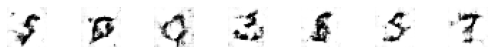

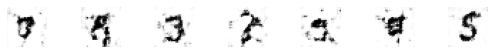

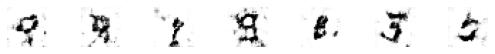

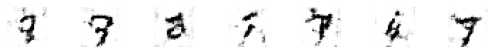

Epoch:4, Step:0, C-Loss:-0.000036, G-Loss:0.012199
Epoch:4, Step:50, C-Loss:-0.000602, G-Loss:0.012950
Epoch:4, Step:100, C-Loss:-0.001023, G-Loss:0.013570
Epoch:4, Step:150, C-Loss:-0.001956, G-Loss:0.014443
Epoch:4, Step:200, C-Loss:-0.000657, G-Loss:0.014356
Epoch:4, Step:250, C-Loss:0.000223, G-Loss:0.014358
Epoch:4, Step:300, C-Loss:-0.000934, G-Loss:0.015237
Epoch:4, Step:350, C-Loss:-0.000400, G-Loss:0.016100
Epoch:4, Step:400, C-Loss:-0.001973, G-Loss:0.016700
Epoch:4, Step:450, C-Loss:-0.000983, G-Loss:0.016257


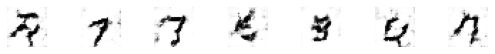

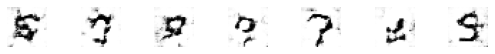

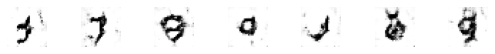

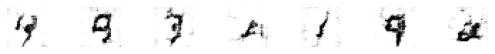

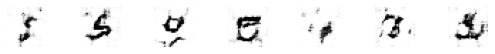

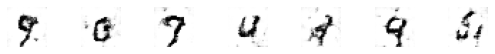

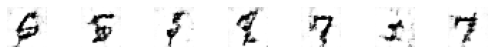

Epoch:5, Step:0, C-Loss:-0.001467, G-Loss:0.016299
Epoch:5, Step:50, C-Loss:-0.000513, G-Loss:0.016597
Epoch:5, Step:100, C-Loss:-0.001554, G-Loss:0.016897
Epoch:5, Step:150, C-Loss:-0.001181, G-Loss:0.018468
Epoch:5, Step:200, C-Loss:-0.001358, G-Loss:0.018115
Epoch:5, Step:250, C-Loss:-0.000244, G-Loss:0.018251
Epoch:5, Step:300, C-Loss:-0.000716, G-Loss:0.018594
Epoch:5, Step:350, C-Loss:0.000051, G-Loss:0.019223
Epoch:5, Step:400, C-Loss:-0.001417, G-Loss:0.018677
Epoch:5, Step:450, C-Loss:-0.001443, G-Loss:0.019574


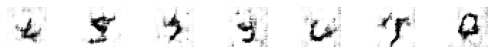

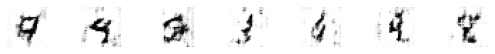

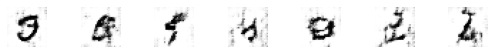

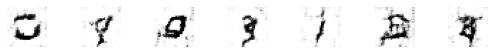

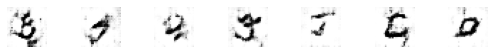

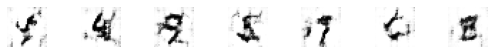

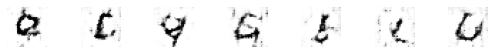

Epoch:6, Step:0, C-Loss:-0.001110, G-Loss:0.019258
Epoch:6, Step:50, C-Loss:0.000543, G-Loss:0.020073
Epoch:6, Step:100, C-Loss:-0.000351, G-Loss:0.020641
Epoch:6, Step:150, C-Loss:-0.001643, G-Loss:0.021322
Epoch:6, Step:200, C-Loss:-0.001448, G-Loss:0.020905
Epoch:6, Step:250, C-Loss:-0.000542, G-Loss:0.021137
Epoch:6, Step:300, C-Loss:-0.003077, G-Loss:0.020926
Epoch:6, Step:350, C-Loss:-0.001596, G-Loss:0.020123
Epoch:6, Step:400, C-Loss:-0.000864, G-Loss:0.020826
Epoch:6, Step:450, C-Loss:-0.000493, G-Loss:0.020065


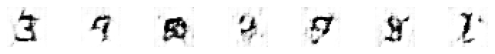

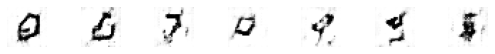

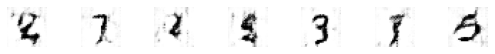

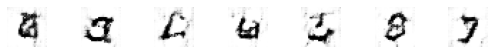

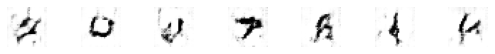

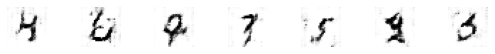

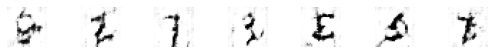

Epoch:7, Step:0, C-Loss:-0.000150, G-Loss:0.018450
Epoch:7, Step:50, C-Loss:-0.000570, G-Loss:0.019369
Epoch:7, Step:100, C-Loss:-0.000194, G-Loss:0.018286
Epoch:7, Step:150, C-Loss:0.000089, G-Loss:0.017158
Epoch:7, Step:200, C-Loss:-0.000731, G-Loss:0.018366
Epoch:7, Step:250, C-Loss:-0.000260, G-Loss:0.016101
Epoch:7, Step:300, C-Loss:0.000227, G-Loss:0.016204
Epoch:7, Step:350, C-Loss:0.000251, G-Loss:0.011614
Epoch:7, Step:400, C-Loss:0.000116, G-Loss:0.013230
Epoch:7, Step:450, C-Loss:-0.000532, G-Loss:0.014047


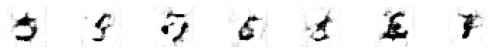

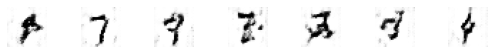

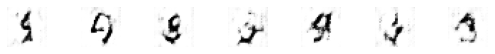

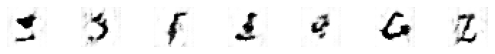

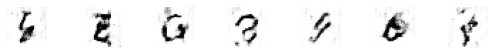

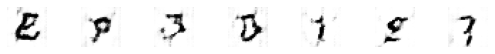

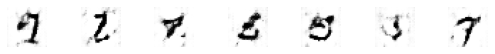

Epoch:8, Step:0, C-Loss:0.000002, G-Loss:0.012970
Epoch:8, Step:50, C-Loss:-0.000329, G-Loss:0.012033
Epoch:8, Step:100, C-Loss:-0.000239, G-Loss:0.012576
Epoch:8, Step:150, C-Loss:-0.000365, G-Loss:0.013519
Epoch:8, Step:200, C-Loss:-0.000332, G-Loss:0.012890
Epoch:8, Step:250, C-Loss:-0.000210, G-Loss:0.011791
Epoch:8, Step:300, C-Loss:-0.000400, G-Loss:0.010134
Epoch:8, Step:350, C-Loss:-0.000789, G-Loss:0.011785
Epoch:8, Step:400, C-Loss:-0.000620, G-Loss:0.009818
Epoch:8, Step:450, C-Loss:0.000096, G-Loss:0.004509


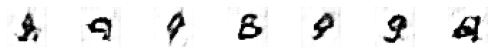

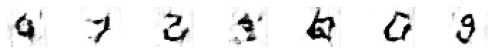

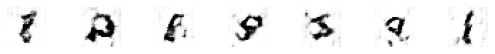

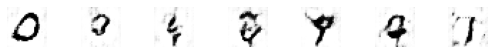

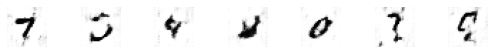

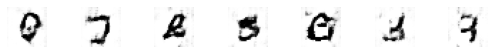

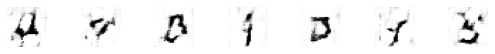

Epoch:9, Step:0, C-Loss:-0.000539, G-Loss:0.008917
Epoch:9, Step:50, C-Loss:-0.000259, G-Loss:0.007371
Epoch:9, Step:100, C-Loss:0.000031, G-Loss:0.006031
Epoch:9, Step:150, C-Loss:-0.000367, G-Loss:0.006614
Epoch:9, Step:200, C-Loss:-0.000382, G-Loss:0.006037
Epoch:9, Step:250, C-Loss:0.000096, G-Loss:0.003679
Epoch:9, Step:300, C-Loss:-0.000034, G-Loss:0.003081
Epoch:9, Step:350, C-Loss:0.000222, G-Loss:0.004052
Epoch:9, Step:400, C-Loss:-0.000468, G-Loss:0.005828
Epoch:9, Step:450, C-Loss:0.000072, G-Loss:0.004168


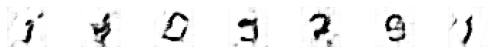

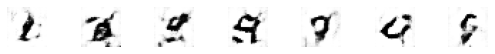

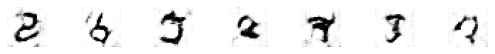

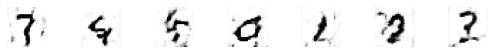

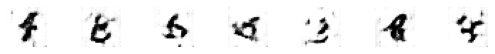

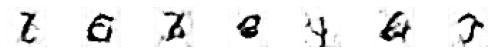

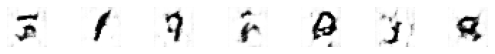

Epoch:10, Step:0, C-Loss:-0.000349, G-Loss:0.005892
Epoch:10, Step:50, C-Loss:-0.000065, G-Loss:0.004455
Epoch:10, Step:100, C-Loss:0.000054, G-Loss:0.005878
Epoch:10, Step:150, C-Loss:-0.000062, G-Loss:0.005165
Epoch:10, Step:200, C-Loss:0.000018, G-Loss:0.005693
Epoch:10, Step:250, C-Loss:-0.000215, G-Loss:0.004527
Epoch:10, Step:300, C-Loss:-0.000229, G-Loss:0.005606
Epoch:10, Step:350, C-Loss:0.000235, G-Loss:0.003865
Epoch:10, Step:400, C-Loss:-0.000310, G-Loss:0.004574
Epoch:10, Step:450, C-Loss:-0.000132, G-Loss:0.004698


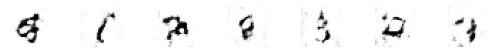

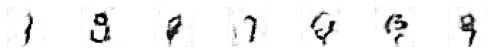

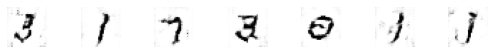

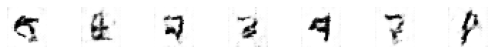

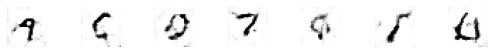

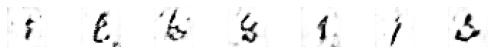

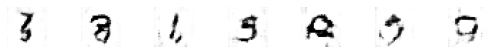

Epoch:11, Step:0, C-Loss:-0.000072, G-Loss:0.005604
Epoch:11, Step:50, C-Loss:-0.000432, G-Loss:0.005697
Epoch:11, Step:100, C-Loss:0.000176, G-Loss:0.005974
Epoch:11, Step:150, C-Loss:-0.000591, G-Loss:0.006909
Epoch:11, Step:200, C-Loss:0.000009, G-Loss:0.006262
Epoch:11, Step:250, C-Loss:-0.000782, G-Loss:0.007498
Epoch:11, Step:300, C-Loss:0.000260, G-Loss:0.006363
Epoch:11, Step:350, C-Loss:-0.000218, G-Loss:0.007554
Epoch:11, Step:400, C-Loss:0.000060, G-Loss:0.006928
Epoch:11, Step:450, C-Loss:0.000475, G-Loss:0.007874


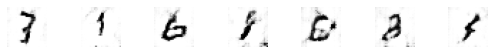

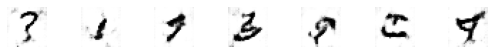

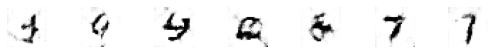

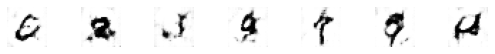

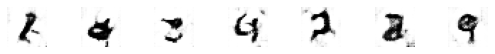

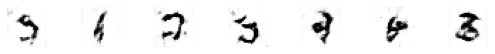

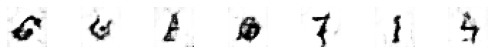

Epoch:12, Step:0, C-Loss:-0.000048, G-Loss:0.008113
Epoch:12, Step:50, C-Loss:-0.000068, G-Loss:0.007844
Epoch:12, Step:100, C-Loss:0.000555, G-Loss:0.008045
Epoch:12, Step:150, C-Loss:0.000338, G-Loss:0.008350
Epoch:12, Step:200, C-Loss:-0.000649, G-Loss:0.009267
Epoch:12, Step:250, C-Loss:-0.000569, G-Loss:0.009541
Epoch:12, Step:300, C-Loss:0.000747, G-Loss:0.008795
Epoch:12, Step:350, C-Loss:-0.000111, G-Loss:0.008273
Epoch:12, Step:400, C-Loss:-0.000729, G-Loss:0.010073
Epoch:12, Step:450, C-Loss:-0.001070, G-Loss:0.010179


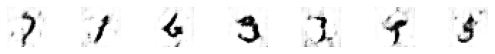

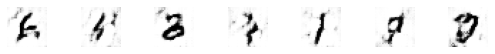

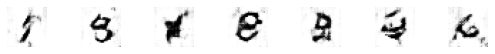

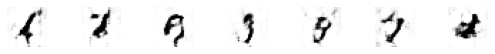

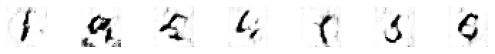

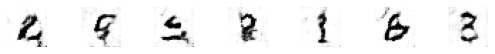

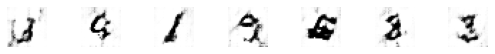

Epoch:13, Step:0, C-Loss:-0.000408, G-Loss:0.009872
Epoch:13, Step:50, C-Loss:-0.000409, G-Loss:0.010068
Epoch:13, Step:100, C-Loss:-0.000116, G-Loss:0.010594
Epoch:13, Step:150, C-Loss:-0.000710, G-Loss:0.010890
Epoch:13, Step:200, C-Loss:-0.000531, G-Loss:0.011280
Epoch:13, Step:250, C-Loss:-0.001200, G-Loss:0.011377
Epoch:13, Step:300, C-Loss:-0.000109, G-Loss:0.010830
Epoch:13, Step:350, C-Loss:-0.000781, G-Loss:0.011895
Epoch:13, Step:400, C-Loss:0.000230, G-Loss:0.011278
Epoch:13, Step:450, C-Loss:-0.000842, G-Loss:0.012104


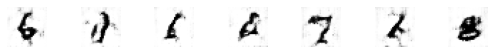

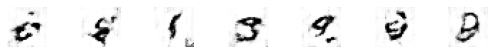

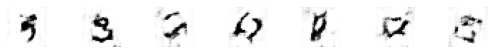

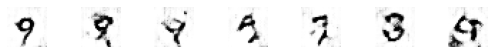

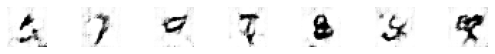

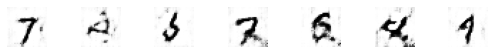

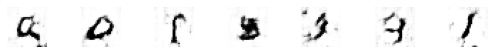

Epoch:14, Step:0, C-Loss:-0.000202, G-Loss:0.010952
Epoch:14, Step:50, C-Loss:-0.001445, G-Loss:0.012337
Epoch:14, Step:100, C-Loss:-0.000120, G-Loss:0.011414
Epoch:14, Step:150, C-Loss:-0.000648, G-Loss:0.012230
Epoch:14, Step:200, C-Loss:-0.000850, G-Loss:0.012650
Epoch:14, Step:250, C-Loss:0.000511, G-Loss:0.012342
Epoch:14, Step:300, C-Loss:-0.000691, G-Loss:0.011473
Epoch:14, Step:350, C-Loss:-0.000996, G-Loss:0.012184
Epoch:14, Step:400, C-Loss:-0.000476, G-Loss:0.013080
Epoch:14, Step:450, C-Loss:-0.000566, G-Loss:0.013328


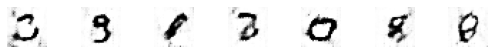

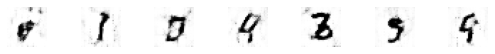

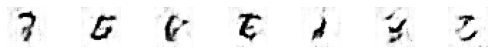

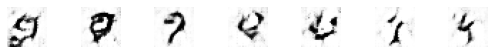

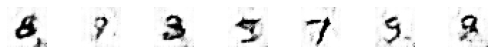

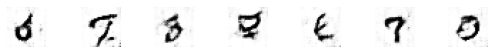

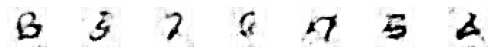

Epoch:15, Step:0, C-Loss:-0.001769, G-Loss:0.012814
Epoch:15, Step:50, C-Loss:-0.000808, G-Loss:0.012224
Epoch:15, Step:100, C-Loss:-0.000255, G-Loss:0.012077
Epoch:15, Step:150, C-Loss:-0.000149, G-Loss:0.011028
Epoch:15, Step:200, C-Loss:-0.000791, G-Loss:0.011580
Epoch:15, Step:250, C-Loss:-0.000039, G-Loss:0.011228
Epoch:15, Step:300, C-Loss:-0.001362, G-Loss:0.012839
Epoch:15, Step:350, C-Loss:0.000123, G-Loss:0.011722
Epoch:15, Step:400, C-Loss:-0.000422, G-Loss:0.011593
Epoch:15, Step:450, C-Loss:-0.001849, G-Loss:0.013212


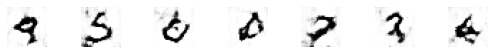

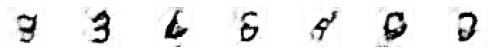

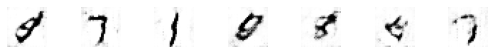

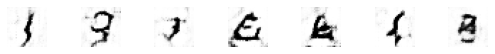

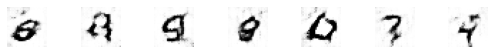

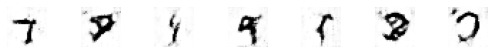

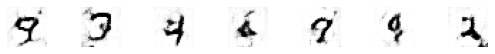

Epoch:16, Step:0, C-Loss:-0.001028, G-Loss:0.012690
Epoch:16, Step:50, C-Loss:-0.000334, G-Loss:0.011003
Epoch:16, Step:100, C-Loss:-0.000284, G-Loss:0.012091
Epoch:16, Step:150, C-Loss:-0.001276, G-Loss:0.013014
Epoch:16, Step:200, C-Loss:0.000264, G-Loss:0.009901
Epoch:16, Step:250, C-Loss:-0.000868, G-Loss:0.012226
Epoch:16, Step:300, C-Loss:0.000201, G-Loss:0.013027
Epoch:16, Step:350, C-Loss:-0.000569, G-Loss:0.010973
Epoch:16, Step:400, C-Loss:0.000728, G-Loss:0.010607
Epoch:16, Step:450, C-Loss:-0.000377, G-Loss:0.012197


In [ ]:
epochs = 500
batch_size = 64
steps = 500
noise_size = 100

for i in range(0, epochs):
    if (i%1 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        # With Number of Critics=5
        for _ in range(5):
            fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
            real_samples = get_real_samples(batch_size=batch_size//2)

            fake_y = np.ones((batch_size//2, 1))
            real_y = -1 * np.ones((batch_size//2, 1))

            # Updating Critic weights

            critic_network.trainable=True
            loss_c_real = critic_network.train_on_batch(real_samples, real_y)
            loss_c_fake = critic_network.train_on_batch(fake_samples, fake_y)
            
            loss_c = np.add(loss_c_real, loss_c_fake)/2.0

            # Clip critic weights
            for l in critic_network.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -0.01, 0.01) for w in weights]
                l.set_weights(weights)
            
            if False:
                print ("C_real_loss: %.3f, C_fake_loss: %.3f, C_loss: %.3f"%(loss_c_real[0], loss_c_fake[0], loss_c[0]))
        
        noise_batches = get_random_noise(batch_size, noise_size)
        
        wgan_input = noise_batches
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        wgan_output = -1 * np.ones((batch_size, 1))
        
        # Updating Generator weights
        critic_network.trainable=False
        loss_g = wgan_model.train_on_batch(wgan_input, wgan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, C-Loss:%.6f, G-Loss:%.6f"%(i,j,loss_c[0] ,loss_g))

In [ ]:
for i in range(2):
    show_generator_results(generator_network)
    print("-"*100)